<a href="https://colab.research.google.com/github/KevinTheRainmaker/ML_DL_Basics/blob/master/HonGong_ML_DL/17_Upgrade_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신경망 모델 훈련

### **키워드:** 드롭아웃, 콜백, 조기 종료

인공 신경망 모델을 훈련하는 모범 사례와 필요한 도구들에 대해 알아보고, 이를 다뤄봄으로써 텐서플로우와 케라스 API에 익숙해져보자.

In [1]:
# packages
import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## 데이터셋

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

train_scaled = X_train / 255.0
train_scaled, val_scaled, y_train, y_val = train_test_split(train_scaled, y_train, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


In [5]:
# Define Model
def model_fn(a_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28)))
  model.add(keras.layers.Dense(100, activation='relu', name='hidden_1'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation='softmax', name='output'))

  return model

## 손실 곡선

케라스의 `fit()` 메서드는 History 클래스 객체를 반환한다. History 객체에는 훈련 과정에서 계산한 지표인 손실과 정확도 값이 저장되어있어, 이를 이용해 에포크 별 손실값에 대한 그래프를 그릴 수 있다.

이렇게 그려지는 그래프를 손실 그래프, 혹은 손실 곡선이라고 한다.

In [10]:
model = model_fn()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 hidden_1 (Dense)            (None, 100)               78500     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, y_train, epochs=5, verbose=0) # verbose: 0(조용히) / 1(기본) / 2(진행막대 제외 출력)

history 객체에는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어있다.

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


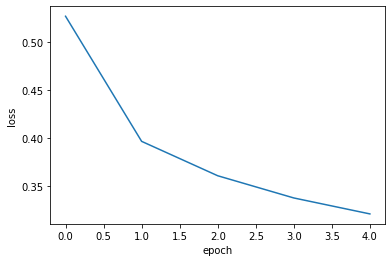

In [15]:
# 손실 곡선
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

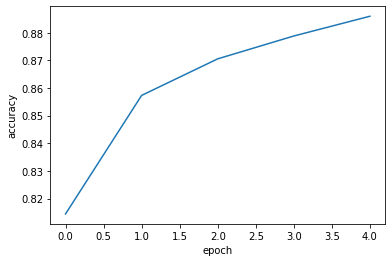

In [16]:
# 정확도 곡선
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

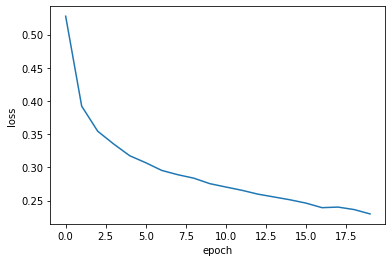

In [17]:
# 20 epochs
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, y_train, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

In [18]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, y_train, epochs=20, verbose=0, validation_data=(val_scaled, y_val))

In [19]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


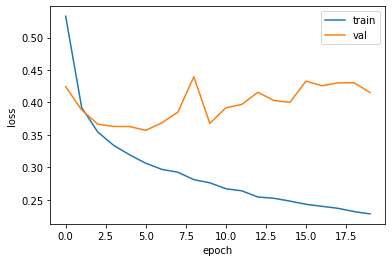

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

꾸준히 감소하는 train_loss와 달리 val_loss는 5번째 에포크부터 상승하고있다. 즉, 과대적합이 일어난 것이다.

과대적합을 방지하기 위해서 사용하는 방법은 여러가지가 있다.

먼저 옵티마이저를 Adam으로 바꾸는 방법부터 시도해보도록 하자.

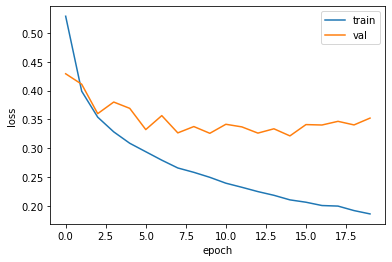

In [21]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, y_train, epochs=20, verbose=0, validation_data=(val_scaled, y_val))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

과대적합이 확실히 줄어들었음을 확인할 수 있다.

학습률을 조정하는 방식으로 과대적합을 줄일 수도 있다. 이 방법을 추가로 적용해보자.

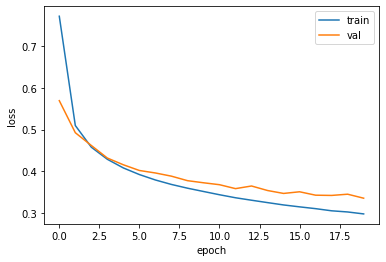

In [27]:
model = model_fn()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, y_train, epochs=20, verbose=0, validation_data=(val_scaled, y_val), use_multiprocessing=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

학습률을 기본값 0.001에서 0.0001로 10배 변경한 결과 과대적합이 상당히 해소되었음을 확인할 수 있다.

## 드롭아웃

딥러닝의 아버지 제프리 힌턴(Geoffrey Hinton)이 고안한 방법론인 드롭아웃(Drop-out)은 훈련 과정 층에 있는 일부 뉴런의 출력값을 랜덤하게 0으로 만들어서 과대적합을 막는다.

뉴런의 선택은 샘플마다 다르게 이루어지며, 얼마나 많은 뉴런을 선택하여 꺼버릴지는 하이퍼 파라미터 형식으로 조절가능하다.

이전 층의 일부 뉴런이 꺼지면 특정 뉴런에 대한 과대한 의존성이 사라지게 되고 이는 과대적합을 막는 동시에 더욱 안정적인 예측을 수행할 수 있게한다.

케라스에서는 `keras.layers` 아래 `Dropout` 클래스를 제공한다. 앞서 정의한 `model_fn()`에 드롭아웃층을 추가해 30%의 뉴런을 선택하도록 하여 학습을 수행해보자.

In [28]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 hidden_1 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


드롭아웃층은 입력 크기가 이전 레이어와 동일하며, 계산을 수행하는 파라미터의 개수는 0이다. 학습에서는 드롭아웃을 적용하여 과대적합을 방지하지만, 검증과 테스트에서는 드롭아웃을 적용하지 않아야 한다는 점을 기억하자. (물론 케라스는 상당히 똑똑한 API이기 때문에 따로 드롭아웃층을 없애주지 않아도 자동으로 드롭아웃을 적용하지 않고 검증을 수행한다.)

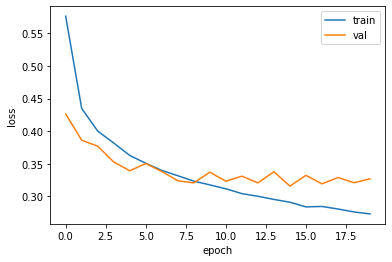

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, y_train, epochs=20, verbose=0, validation_data=(val_scaled, y_val), use_multiprocessing=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

10번째 에포크 정도에서 검증 손실이 더 이상 유의미한 감소를 보이지는 않지만, 딱히 상승하지도 않고 있다.

위 모델은 20번의 에포크를 수행했기 때문에 약간 과대적합되었다고 볼 수 있다. 따라서 10번으로 에포크 수를 줄여 과대적합을 해소하자.

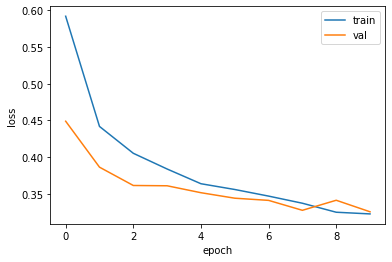

In [31]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, y_train, epochs=10, verbose=0, validation_data=(val_scaled, y_val), use_multiprocessing=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

## 모델 저장과 복원

에포크 횟수를 10으로 하여 모델을 학습하였다. 이것을 나중에 사용하기 위해서는 모델을 저장해야한다.

케라스 모델은 훈련한 모델의 파라미터를 저장하는 `save_weights()` 메서드를 제공한다. 이는 기본적으로 텐서플로우 체크포인트 포맷으로 저장하지만, 파일의 확장자가 h5인 경우 HDF5 형식으로 모델 파라미터를 저장한다.

In [32]:
model.save_weights('model-weight.h5')

또한 모델 구조와 모델 파라미터를 함께 저장하는 `save()` 메서드도 제공한다. 이는 기본적으로 텐서플로우의 SavedModel 포맷으로 저장하지만, 위와 마찬가지로 확장자가 h5인 경우 HDF5 형식으로 모델을 저장한다.

In [33]:
model.save('model-whole.h5')

두 가지 방법을 이용해서 모델을 훈련해보자.

1. `model-weights.h5`에서 파라미터를 불러와서 새로운 모델을 학습

2. `model-whole.h5`에서 훈련된 모델 자체를 불러와서 사용

In [38]:
# 1
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weight.h5')

훈련하지 않은 새로운 모델을 만들어 기존에 저장했던 모델의 파라미터를 불러와 적재시켰다. 이때 만들어지는 새로운 모델은 기존 모델과 정확히 같은 구조를 가져야한다.

In [39]:
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == y_val))

0.8820833333333333


\*  axis: -1(배열의 마지막 차원을 따라 최댓값 선택) / 1(열을 따라 각 행의 최댓값 인덱스 선택) / 0(행을 따라 각 열의 최댓값 인덱스 선택)

In [40]:
# 2
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, y_val)

375/375 [==============================] - 1s 2ms/step - loss: 0.3255 - accuracy: 0.8821


[0.3255208432674408, 0.8820833563804626]

`load_model()` 함수는 모델 파라미터뿐만 아니라 모델 구조와 옵티마이저 상태까지 모두 복원하기 때문에 `evaluate()` 메서드를 사용할 수 있다.

\* 텐서플로우 2.3에서는 `load_model()` 함수의 버그 때문에 `evaluate()` 사용 전 `compile()`을 수행해줘야 한다.

## 콜백

앞서 우리는 모델을 20 에포크로 훈련 후 10 에포크에서 검증 손실이 줄어들지 않음을 확인했고, 이에 따라 에포크 수를 10으로 줄여 다시 훈련을 진행했다.

하지만 콜백(CallBack) 함수를 사용하면 두 번씩 모델을 훈련하지 않고도 과대적합되지 않는 최적의 에포크 수를 찾아 훈련할 수 있다.

콜백은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 `keras.callbacks` 패키지 아래에 있는 클래스들이다. `fit()` 메서드의 callbacks 매개변수에 리스트로 전달하여 사용한다.

ModelCheckpint 콜백은 기본적으로 최상의 검증 점수를 만드는 모델을 저장한다.

In [41]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')

model.fit(train_scaled, y_train, epochs=20, validation_data=(val_scaled, y_val), callbacks=[checkpoint_cb])

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5954 - accuracy: 0.7907 - val_loss: 0.4201 - val_accuracy: 0.8461
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4403 - accuracy: 0.8407 - val_loss: 0.3943 - val_accuracy: 0.8518
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4040 - accuracy: 0.8524 - val_loss: 0.3636 - val_accuracy: 0.8642
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3804 - accuracy: 0.8605 - val_loss: 0.3538 - val_accuracy: 0.8689
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3678 - accuracy: 0.8641 - val_loss: 0.3429 - val_accuracy: 0.8723
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3530 - accuracy: 0.8697 - val_loss: 0.3501 - val_accuracy: 0.8723
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3446 - accuracy: 0.8732 - val_loss: 0.3389 - val_accuracy:

`model_fn()` 함수로 모델을 만들고 `compile()` 메서드를 호출하는 것은 동일하나, ModelCheckpoint 클래스의 객체 `checkpoint_cb`를 만든 후 `fit()` 메서드의 callbacks 매개변수에 리스트로 전달한다.

모델은 훈련을 통해 최상의 검증 점수를 가진 모델을 찾게 되고, 그 모델은 best-model.h5에 저장된다.

In [42]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, y_val)

375/375 [==============================] - 1s 1ms/step - loss: 0.3103 - accuracy: 0.8883


[0.3103382885456085, 0.8883333206176758]

기존에 두 번에 걸쳐 진행한 학습이 한 번으로 줄어들어 상당히 편리해졌다. 다만 무의미하게도, 여전히 20번의 에포크를 수행하고 있다. 이때 검증 점수가 더 올라가지 않으면 학습을 중지하면 컴퓨터 리소스와 시간을 아낄 수 있다. 이를 조기 종료(Early-stopping)이라고 하며, 딥러닝 분야에서 널리 사용되는 기법이다. 조기 종료는 훈련 에포크 수를 제한하는 역할이지만 모델이 과대적합을 막아 주는 규제 방법의 일종으로 생각할 수도 있다.

케라스에는 조기 종료를 위한 EarlyStopping 콜백을 제공한다. 이 콜백의 patience 매개변수로 검증 점수가 향상되지 않더라도 참을(patience) 에포크 수를 지정할 수 있다. 

또한 restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다.


In [45]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, y_train, epochs=20, validation_data=(val_scaled, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5921 - accuracy: 0.7939 - val_loss: 0.4342 - val_accuracy: 0.8422
Epoch 2/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4383 - accuracy: 0.8419 - val_loss: 0.3865 - val_accuracy: 0.8609
Epoch 3/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4019 - accuracy: 0.8546 - val_loss: 0.3835 - val_accuracy: 0.8600
Epoch 4/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3798 - accuracy: 0.8608 - val_loss: 0.3631 - val_accuracy: 0.8679
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3649 - accuracy: 0.8650 - val_loss: 0.3573 - val_accuracy: 0.8695
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3501 - accuracy: 0.8711 - val_loss: 0.3381 - val_accuracy: 0.8740
Epoch 7/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3404 - accuracy: 0.8734 - val_loss: 0.3266 - val_accuracy:

12번째 에포크에서 학습을 멈추었다.

이는 `early_stopping_cb` 객체의 `stopped_epoch` 속성에서 확인할 수 있다.

In [44]:
print(early_stopping_cb.stopped_epoch)

11


11은 12번째 에포크에서 훈련이 중지되었다는 것을 의미한다. patience를 2로 지정했으므로 최상의 모델은 10번째 에포크일 것이다.

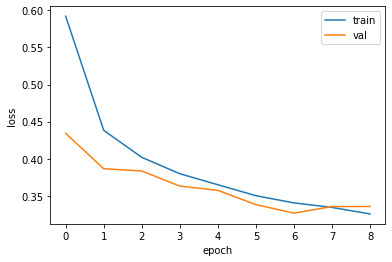

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [47]:
model.evaluate(val_scaled, y_val)

375/375 [==============================] - 1s 1ms/step - loss: 0.3266 - accuracy: 0.8796


[0.3266178071498871, 0.8795833587646484]